# Part 3: Pre-processing

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import json

In [24]:
def set_indexes(dfs):
    for df in dfs:
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date", inplace=True)

In [62]:
regions = ["New England", "Mid Atlantic", "South", "Midwest", "Southwest", "West"]
new_england = "New England"
mid_atlantic = "Mid Atlantic"
south = "South"
midwest = "Midwest"
southwest = "Southwest"
west = "West"

In [27]:
new_england_df = pd.read_csv("../data/cleaned_new_england_covid.csv")
mid_atlantic_df = pd.read_csv("../data/cleaned_mid_atlantic_covid.csv")
south_df = pd.read_csv("../data/cleaned_south_covid.csv")
midwest_df = pd.read_csv("../data/cleaned_midwest_covid.csv")
southwest_df = pd.read_csv("../data/cleaned_southwest_covid.csv")
west_df = pd.read_csv("../data/cleaned_west_covid.csv")

In [30]:
set_indexes([new_england_df, mid_atlantic_df, south_df, midwest_df, southwest_df, west_df])

In [131]:
def get_best_model(X_train, X_test, y_train, y_test):
    exp_10 = np.logspace(-4,4,30)
    best_model = None
    best_acc = -np.inf
    for i in exp_10:
        lasso_reg = Lasso(alpha=i, max_iter=20000)
        lasso_reg.fit(X_train, y_train)
        test_acc = lasso_reg.score(X_test, y_test)
        nfeat = np.count_nonzero(lasso_reg.coef_)
        if test_acc > best_acc and nfeat <= 15: # limit to top 15 features
            best_model = lasso_reg
            best_acc = test_acc
    return best_model

In [133]:
def get_features_by_region(dfs, scaled=False):
    """
    Returns a map of region to features using lasso
    """
    features_by_region = {}
    coefs_by_region = {}
    for df in dfs:
        region = df.iloc[0,].region
        df_means = df.groupby("date").mean(numeric_only=True)
        X = df_means.drop(columns=["critical_staffing_shortage_today_yes"])
        y = df_means[["critical_staffing_shortage_today_yes"]]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
        if scaled:
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        best_model = get_best_model(X_train, X_test, y_train, y_test)

        # filter out indices that Lasso has deemed 0
        indices = []
        coefs = {}
        for i, coef in enumerate(best_model.coef_):
            if abs(coef) > 0:
                indices.append(i)
                coefs[i] = coef
                
        features = []
        coefs_map = {}
        for index in indices:
            column_name = df_means.drop(columns=["critical_staffing_shortage_today_yes"]).columns[index]
            features.append(column_name)
            coefs_map[column_name] = coefs[index]
            
        # Only return statistically significant columns
        columns_exclude = list(set(X.columns) - set(features))
        X = df_means.drop(columns=["critical_staffing_shortage_today_yes", *columns_exclude])
        y = df_means["critical_staffing_shortage_today_yes"]

        statistically_significant_columns = []
        for column in X.columns:
            result = stats.pearsonr(X[column], y)
            if result.pvalue < 0.05:
                statistically_significant_columns.append(column)
            else:
                del coefs_map[column]

        features_by_region[region] = statistically_significant_columns
        coefs_by_region[region] = coefs_map
    return features_by_region, coefs_by_region

This runs slowly, but it's a brute force way of getting some parameters for some modeling.

In [135]:
features_by_region_s, coefs_by_region_s = get_features_by_region([new_england_df, mid_atlantic_df, south_df, midwest_df, southwest_df, west_df], 
                                                                 scaled=True)

/opt/anaconda3/envs/plotly_bokeh/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9478306022815275, tolerance: 0.5515770004572477
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/plotly_bokeh/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5736283265975866, tolerance: 0.5515770004572477
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/plotly_bokeh/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.502036598634846, tolerance: 1.2663833653406498
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/plotly_bokeh/lib/python3.8/sit

In [137]:
sorted_coefs = {}
regions = [new_england, mid_atlantic, south, midwest, southwest, west]
for region in regions:
    sorted_coefs[region] = {k: v for k, v in sorted(coefs_by_region_s[region].items(), key=lambda item: item[1], reverse=True)}

In [139]:
# Convert coefs and write JSON object to file
with open("../data/coefs_region.json", "w") as outfile: 
    json.dump(sorted_coefs, outfile)

In [144]:
mid_atlantic_cols = sorted_coefs[mid_atlantic].keys()

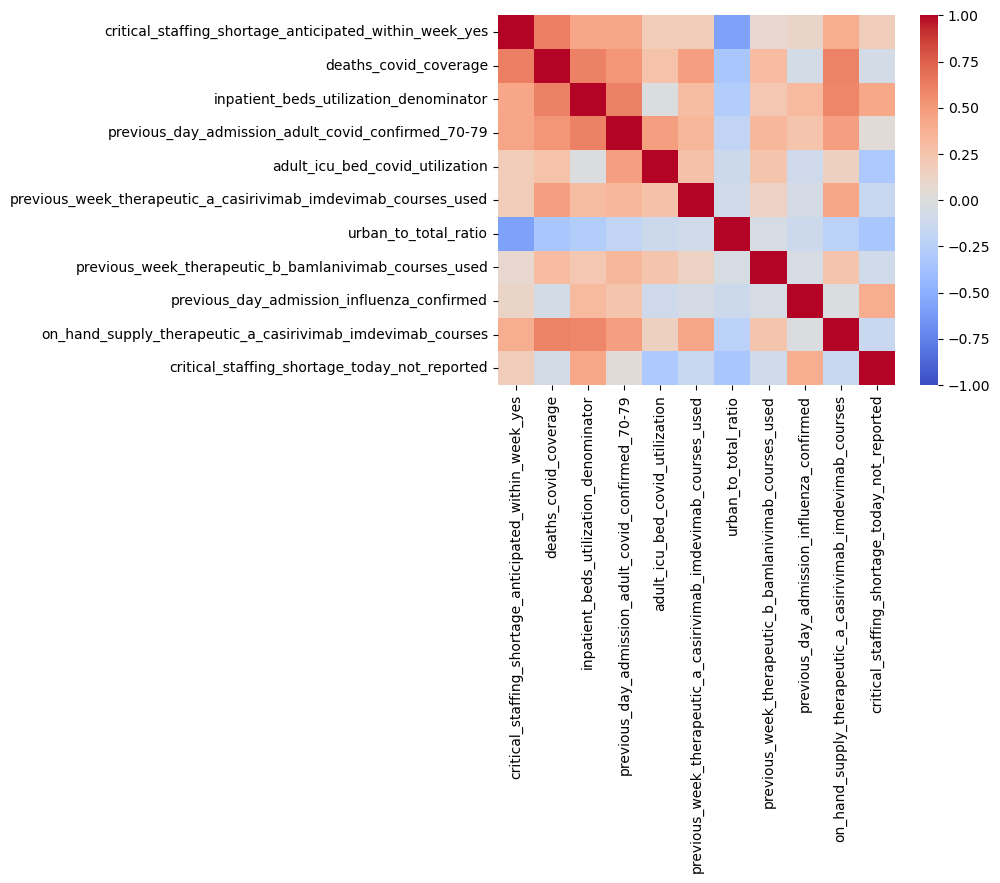

In [164]:
mid_atlantic_heatmap = sns.heatmap(mid_atlantic_df[mid_atlantic_cols].corr(), cmap="coolwarm", vmin=-1.0, vmax=1.0)
fig = mid_atlantic_heatmap.get_figure()
fig.savefig("../img/mid_atlantic_heatmap", bbox_inches='tight')